In [3]:
import torch
import sys
sys.path.append('..')

from train import BBBBNN
import pandas as pd


from train_utils import load_signal_data, make_performance_uncertainty_plot
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("paper")
sns.plotting_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model = BBBBNN(in_dim=44, n_classes=1, pos_weight=torch.Tensor([1/0.0845]))
model.load_state_dict(torch.load('../models/bnn/78.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
train_data, train_labels, test_data, test_labels = load_signal_data('../data/processed/')

In [6]:
n_samples = 512

outputs = torch.empty(n_samples, len(test_data), model.n_classes)
with torch.no_grad():
    for i in range(n_samples):
        outputs[i] = model(test_data, sample=True)
    

outputs = torch.sigmoid(outputs)

In [7]:
predictions = outputs.mean(0).squeeze(-1).numpy()
labels = test_labels.numpy()
uncertainties = outputs.std(0).squeeze(-1).numpy()

In [8]:
predictions_positive = predictions[labels == 1]
predictions_negative = predictions[labels == 0]

uncertainties_positive = uncertainties[labels == 1]
uncertainties_negative = uncertainties[labels == 0]


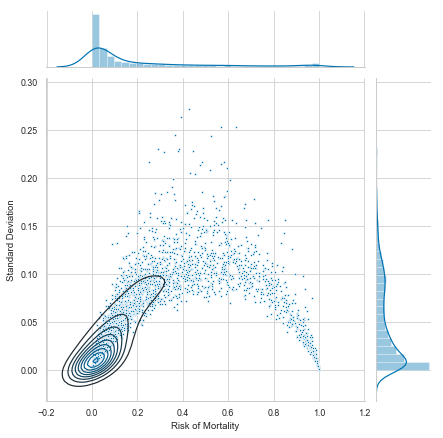

In [9]:


g = sns.JointGrid(x=predictions.squeeze(), y=uncertainties.squeeze())
g.plot_joint(sns.scatterplot, marker='.')
g.plot_marginals(sns.distplot)
g.plot_joint(sns.kdeplot, shade=False)
plt.ylabel('Standard Deviation')
plt.xlabel('Risk of Mortality')
plt.show()


In [10]:
X_train_raw, X_test_raw = (pd.read_csv('../data/processed/X_train_raw.csv'),
                          pd.read_csv('../data/processed/X_test_raw.csv'))

X_train_processed, X_test_processed = (pd.read_csv('../data/processed/X_train_processed.csv'),
                          pd.read_csv('../data/processed/X_test_processed.csv'))

In [11]:
from lightgbm import LGBMClassifier

/Users/david/miniconda2/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [12]:
lgbm = LGBMClassifier()

In [13]:
lgbm.fit(X_train_processed, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
preds_lgbm = lgbm.predict_proba(X_test_processed)[:, 1]

In [15]:
roc_auc_score(test_labels, preds_lgbm)

0.9318422979587119

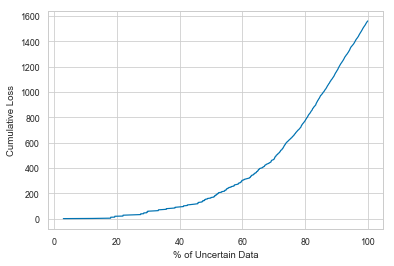

In [16]:
fig = make_performance_uncertainty_plot(test_labels.squeeze().numpy(), predictions, uncertainties, y_axis_label='Cumulative Loss',
                                 performance_fn_args={'reduction': 'sum'})





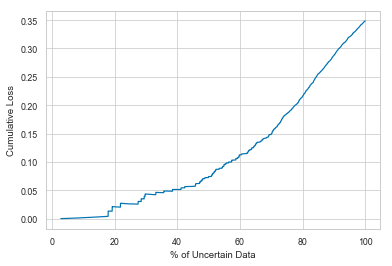

In [17]:
fig = make_performance_uncertainty_plot(test_labels.squeeze().numpy(), predictions, uncertainties, y_axis_label='Cumulative Loss',
                                 performance_fn_args={'reduction': 'mean'})





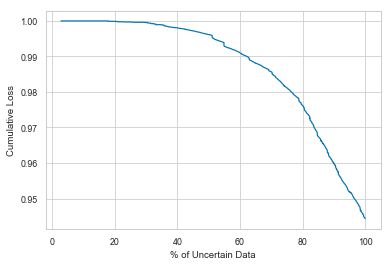

In [18]:
fig = make_performance_uncertainty_plot(test_labels.squeeze().numpy(), predictions, uncertainties, y_axis_label='Cumulative Loss',
                                 performance_fn=roc_auc_score)





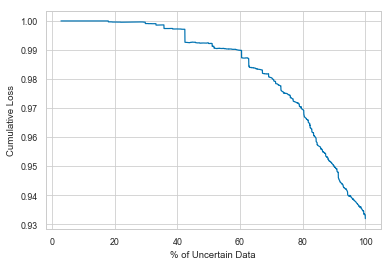

In [19]:
fig = make_performance_uncertainty_plot(test_labels.squeeze().numpy(), preds_lgbm, uncertainties, y_axis_label='Cumulative Loss',
                                 performance_fn=roc_auc_score)





# Newborns

In [20]:
mean_age = X_train_processed['age'].mean()

In [21]:
dataset_dir = '../data/processed/'

y_newborn = pd.read_csv(os.path.join(dataset_dir, 'y_newborns.csv'), squeeze=True)
X_newborn = pd.read_csv(os.path.join(dataset_dir, 'X_newborns.csv'))
X_newborn['age'] = mean_age

labels_newborn: torch.Tensor = torch.from_numpy(y_newborn.values)
data_newborn: torch.Tensor = torch.from_numpy(X_newborn.values).float()


In [22]:

outputs_newborn = torch.empty(n_samples, len(data_newborn), model.n_classes)
with torch.no_grad():
    for i in range(n_samples):
        outputs_newborn[i] = model(data_newborn, sample=True)
    

outputs_newborn = torch.sigmoid(outputs_newborn)

In [23]:
predictions_newborn = outputs_newborn.mean(0).squeeze(-1).numpy()
labels_newborn = labels_newborn.numpy()
uncertainties_newborn = outputs_newborn.std(0).squeeze(-1).numpy()

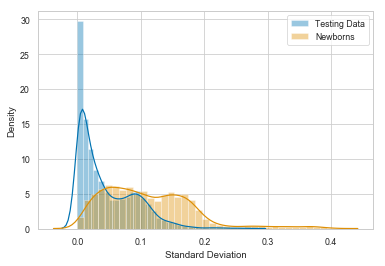

In [24]:
sns.distplot(uncertainties, label='Testing Data')
sns.distplot(uncertainties_newborn, label='Newborns')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')
plt.legend()

Text(0, 0.5, 'Loss')

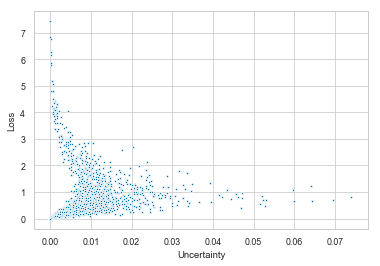

In [25]:
from train_utils import cross_entropy

ce = cross_entropy(test_labels.numpy(), predictions)

sns.scatterplot(np.square(uncertainties.squeeze()), ce, marker='.')
plt.xlabel('Uncertainty')
plt.ylabel('Loss')

In [26]:
uncertainties_newborn.mean() / uncertainties.mean()

2.447389

In [27]:
predictions = predictions.squeeze()

# Detecting Incorrect Classifications

In [37]:
from sklearn.metrics import average_precision_score


In [38]:
predictions_softmax = np.vstack((1 - predictions, predictions)).T

succes_labels = np.zeros(len(predictions_softmax))
correct_predictions = predictions_softmax.argmax(-1) == test_labels.numpy()
succes_labels[correct_predictions] = 1

error_labels = 1 - succes_labels

In [39]:
roc_auc_score(succes_labels, 1 - uncertainties)

0.8535130050666816

In [40]:
average_precision_score(succes_labels, 1 - uncertainties)

0.9811512645768224

In [41]:
average_precision_score(error_labels, uncertainties)

0.3103669614689724

# Detecting OOD

In [42]:
predictions_newborn = predictions_newborn.squeeze()

In [43]:
predictions_cat = np.concatenate((predictions, predictions_newborn))
predictions_cat_softmax = np.vstack(([1 - predictions_cat, predictions_cat])).T

uncertainties_cat = np.concatenate((uncertainties, uncertainties_newborn))


In [44]:
in_domain = np.ones(len(predictions_cat))
in_domain[len(predictions_newborn):] = 0

out_domain = 1 - in_domain

In [45]:
roc_auc_score(in_domain, 1 - uncertainties_cat)

0.7519960252324025

In [46]:
average_precision_score(in_domain, 1 - uncertainties_cat)

0.7987446605956993

In [47]:
average_precision_score(out_domain, uncertainties_cat)

0.6910020160969179